# Setup

In [1]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/home_detection/code


In [2]:
from mobilkit.umni import *
from setup import P, Region, Dataset

In [3]:
import shutil

import haversine as hs

In [4]:
SP.start()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/27 14:37:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/04/27 14:37:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/04/27 14:37:39 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/04/27 14:37:39 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


## Create datasets

In [5]:
datasets = [
    Dataset('D1', 'Baton Rouge', (2021, 8, 1), (2021, 8, 25)),
    Dataset('D2', 'Baton Rouge', (2021, 8, 26), (2021, 9, 7)),
    Dataset('D3', 'Baton Rouge', (2021, 9, 8), (2021, 11, 30)),
    Dataset('D4', 'Indianapolis', (2020, 3, 1), (2020, 3, 15)),
    Dataset('D5', 'Indianapolis', (2020, 3, 16), (2020, 3, 31)),
    Dataset('D6', 'Indianapolis', (2020, 3, 1), (2020, 3, 31)),
    Dataset('D7', 'Austin', (2021, 7, 1), (2021, 7, 7)),
    Dataset('D8', 'Houston', (2021, 7, 1), (2021, 7, 7)),
]; ds2 = datasets[1]; ds2

Dataset D2(Baton Rouge: 2021-08-26 - 2021-09-07)

In [6]:
regions = sorted(set(x.region for x in datasets), key=lambda x: x.geocode)
regions

[Region(Austin), Region(Baton Rouge), Region(Houston), Region(Indianapolis)]

# Prepare pings

## Filter regional data
Also filter erroneous and unreliable pings (e.g., ones with unrealistic segment speed and acceleration).

In [7]:
filters = [('max_error', 50, 'max_gps_error (m)'),
           ('max_speed', 50, 'max_speed (m/s)'),
           ('max_accel', 10, 'max_acceleration (m/s2)'),
           ('max_decel', 10, 'max_deceleration (m/s2)')]
P.params.set({'filters': {'all_pings': {
    label: val for _, val, label in filters}}})

In [8]:
def filter_pings(ds: Dataset, max_error, max_speed=np.inf, 
                 max_accel=np.inf, max_decel=np.inf, inroot=QUADRANT,
                 in_date_fmt='%Y/%m/%d', pbar=True, save=True,
                 overwrite=False):
    start_time = dt.datetime.now()
    filt_derivatives = any([x != np.inf for x in [
        max_speed, max_accel, max_decel]])
    minx, miny, maxx, maxy = ds.region.bbox
    dates = tqdm(ds.dates) if pbar else ds.dates
    temp = []
    for date in dates:
        outpath = ds.data / f'pings/{date}'
        if outpath.exists() and not overwrite:
            continue
        date_str = date.strftime(in_date_fmt)
        inpath = inroot / ds.region.state.title() / date_str
        if not inpath.exists():
            continue
        df = SP.read_parquet(inpath)
        if filt_derivatives:
            df = mk.gps.get_motion_metrics(df)
            cols = {x: i for i, x in enumerate(df.columns[1:])}
        df = df.select(UID, F.arrays_zip(*cols.keys()).alias('pts'))
        df = df.withColumn('pts', F.udf(lambda pts: [
            tuple(x) for x in pts if x[ERR] <= max_error and 
            minx <= x[LON] <= maxx and miny <= x[LAT] <= maxy
        ], T.array(T.array(T.float)))('pts'))
        df = df.filter(F.size('pts') > 0)
        if filt_derivatives:
            df = df.withColumn('pts', F.udf(lambda pts: list(zip(*[
                tuple(x) for x in pts if 
                0 <= x[cols['speed']] <= max_speed and
                x[cols['accel']] <= max_accel and
                x[cols['accel']] >= -max_decel
            ])), T.array(T.array(T.float)))('pts'))
        df = df.filter(F.size('pts') > 0)
        df = df.select(UID, *[F.col('pts')[i].alias(x) for i, x in
                              enumerate([LON, LAT, TS])])
        temp.append(date)
        if save:
            mk.spark.write(df, outpath)
    if len(temp) > 0:
        print(f'Runtime for {ds}: {dt.datetime.now() - start_time}')

kwargs = {x[0]: x[1] for x in filters}
# %time df = filter_pings(ds2, **kwargs, overwrite=1, save=0); df

In [9]:
# t=3:27:00 (1=>15:38[U5], 2=>5:08[U5], 3=>1:12:56, 4=>6:19, 5=>7:22, 6=>23:48[U1], 7=>37:17[U2], 8=>38:32[U1])
for ds in tqdm(datasets):
    filter_pings(ds, **kwargs, pbar=0, overwrite=0)

  0%|          | 0/8 [00:00<?, ?it/s]

## Ping counts by half-hour slot

In [10]:
slot_size = 30*60 # seconds
P.params.set({'filters.slot_size': slot_size})

In [11]:
def get_ping_counts(ds, slot_size=slot_size, save=True, overwrite=False):
    outfile = ds.data / 'counts.parquet'
    if outfile.exists() and not overwrite:
        return SP.read_parquet(outfile)
    print(f'Processing {ds}')
    start_time = dt.datetime.now()
    def get_slot(t):
        return [int(x / slot_size) for x in t]
    def count(slots):
        return {int(k): int(v) for k, v in zip(
            *np.unique(slots, return_counts=True))}
    res = []
    for date in ds.dates:
        df = SP.read_parquet(ds.data / f'pings/{date}')
        day_num = (date - ds.start).days
        df = df.withColumn('day_id', F.lit(day_num).cast(T.int8))
        df = df.withColumn('slot', F.udf(get_slot, T.array(T.int8))(TS))
        df = df.withColumn('n', F.udf(count, T.map(T.int, T.int))('slot'))
        df = df.select(UID, 'day_id', F.explode('n').alias('slot', 'n_pings'))
        df = df.withColumn('slot', F.col('slot').cast(T.int8))
        df = df.withColumn('n_pings', F.col('n_pings').cast(T.int32))
        res.append(df)
    df = reduce(Sdf.union, res)
    if save:
        df.toPandas().to_parquet(U.mkfile(outfile))
    print(f'Runtime for {ds}: {dt.datetime.now() - start_time}')
    return df

x = get_ping_counts(ds2, overwrite=1, save=0); x
# %time x.select(F.max('slot')).disp(10)

Processing Dataset D2(Baton Rouge: 2021-08-26 - 2021-09-07)


Runtime for Dataset D2(Baton Rouge: 2021-08-26 - 2021-09-07): 0:00:08.692932


DataFrame[uid: bigint, day_id: tinyint, slot: tinyint, n_pings: int]

In [12]:
# t=3:47 (1=>0:28, 2=>0:09, 3=>1:19, 4=>0:16, 5=>0:17, 6=>0:32, 7=>0:10, 8=>0:22)
for ds in tqdm(datasets):
    get_ping_counts(ds, overwrite=False)

  0%|          | 0/8 [00:00<?, ?it/s]

## Nighttime pings

In [13]:
base_day_hrs = (7, 19) # 7am – 7pm
min_total_nightly_pts = 10
P.params.set({'filters': {
    'base_day_hours': list(base_day_hrs),
    'min_total_nightly_pts': min_total_nightly_pts}})

In [14]:
def get_nighttime_pings_one_date(ds, date, start_time, end_time, save, overwrite):
    temp_path = lambda date: ds.data / f'_temp/{date}'
    if temp_path(date).exists() and not overwrite:
        return
    mask = lambda t: (t >= end_time) if date == ds.start else (
        t <= start_time or t >= end_time)
    df = SP.read_parquet(ds.data / f'pings/{date}')
    df = df.select(UID, F.arrays_zip(LON, LAT, TS).alias('pts'))
    df = df.withColumn('pts', F.udf(lambda p: [
        (x, y, t) for x, y, t in p if mask(t)
    ], T.array(T.array(T.float)))('pts'))
    df = df.filter(F.size('pts') > 0)
    df = df.withColumn('pts', F.udf(
        lambda x: list(zip(*x)), T.array(T.array(T.float)))('pts'))
    df = df.select(UID, *[F.col('pts')[i].alias(x) for i, x 
                          in enumerate([LON, LAT, TS])])
    if save:
        mk.spark.write(df, temp_path(date))

In [15]:
def get_nighttime_pings(ds, day_hrs, min_total_pts,
                        save=True, overwrite=False):
    outpath = ds.data / 'night_pings'
    if outpath.exists() and not overwrite:
        return SP.read_parquet(outpath)
    print(f'Processing {ds}')
    start_time = dt.datetime.now()
    start, end = [x * 3600 for x in day_hrs]
    temp_path = lambda date: ds.data / f'_temp/{date}'
    arr = T.array(T.array(T.float))
    for date in ds.dates:
        if temp_path(date).exists() and not overwrite:
            continue
        mask = lambda t: ((t >= end) if date == ds.start else (
            t <= start or t >= end))
        df = SP.read_parquet(ds.data / f'pings/{date}')
        df = df.select(UID, F.arrays_zip(LON, LAT, TS).alias('pts'))
        if date == ds.start:
            udf = lambda pts: [tuple(p) for p in pts if p[2] >= end]
            df = df.withColumn('pts', F.udf(udf, arr)('pts'))
        else:
            udf = lambda pts: [tuple(p) for p in pts if p[2] <= start or p[2] >= end]
            df = df.withColumn('pts', F.udf(udf, arr)('pts'))
        df = df.filter(F.size('pts') > 0)
        df = df.withColumn('pts', F.udf(lambda x: list(zip(*x)), arr)('pts'))
        df = df.select(UID, *[F.col('pts')[i].alias(x) for i, x 
                              in enumerate([LON, LAT, TS])])
        if save:
            mk.spark.write(df, temp_path(date))
    df = []
    for date in ds.dates:
        d = SP.read_parquet(temp_path(date))
        nDays = (date - ds.start).days
        add_day = lambda t: [t + 86400 * nDays for t in t]
        df.append(d.withColumn(TS, F.udf(add_day, T.array(T.float))(TS)))
    df = reduce(Sdf.union, df).withColumn('n', F.size(LON))
    hq_users = (df.groupby(UID).agg(F.sum('n').alias('n'))
                .filter(f'n >= {min_total_pts}').select(UID))
    df = df.join(hq_users, on=UID)
    df = df.groupby(UID).agg(*[F.flatten(F.collect_list(x)).alias(x)
                               for x in [LON, LAT, TS]])
    if save:
        mk.spark.write(df, outpath)
        shutil.rmtree(ds.data / '_temp')
    print(f'Runtime: {dt.datetime.now() - start_time}')
    return df
    
# %time x = get_nighttime_pings(datasets[1], base_day_hrs, min_total_nightly_pts, overwrite=True); x

In [16]:
%%time
# t= (1=>2:28, 2=>0:48, 3=>9:13, 4=>1:23, 5=>1:21, 6=>2:34, 7=>0:57, 8=>2:37)
for ds in datasets:
    get_nighttime_pings(ds, base_day_hrs, min_total_nightly_pts, overwrite=0)

CPU times: user 13.2 ms, sys: 7.04 ms, total: 20.2 ms
Wall time: 1.55 s


# Visualize

## Sample data (for paper)
A small sample file copied from **UMNI-5**:
[/export/scratch/a/verma99/quadrant/Indiana/year=2019/month=03/day=01/20210405_083006_00071_zvatq_bucket-00009.gz data/sample_data.csv.gz]().

In [17]:
def fig_data_sample():
    df = SP.read_csv(P.data / '_etc/sample_data.csv.gz')
    df = mk.gps.read_cols(df)
    df = df.limit(5).toPandas().rename_axis('Row')
    df[TS] = (df[TS] / 1000).astype(int)
    df = df.rename(columns={UID: 'Device ID', LON: 'Longitude', LAT: 'Latitude', 
                   TS: 'Timestamp (s)', ERR: 'GPS Error Radius (m)'})
    df.index = df.index + 1
    return df

x = fig_data_sample(); x

,Device ID,Longitude,Latitude,Timestamp (s),GPS Error Radius (m)
Row,,,,,
1,19460fcc-a1be-4c3b-a395-97bd8540979f,-87.353844,41.596100,1551405798,20.0
2,44bb8fbe-f163-4167-9b9c-e2c906ccee95,-85.654099,40.531002,1551483324,10.0
3,14c9ab69-388d-413d-805a-3d6b444d23eb,-87.431442,38.079304,1551483766,6.0
4,9bb308e2-2064-424b-a564-04dd1c0b5595,-87.011955,41.464821,1551403946,12.0
5,c980624b-1603-4d60-be65-d4ef96388e09,-85.221809,41.053005,1551460827,8.0


## Hourly distribution

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 5.08 s, sys: 5.94 s, total: 11 s
Wall time: 19.4 s


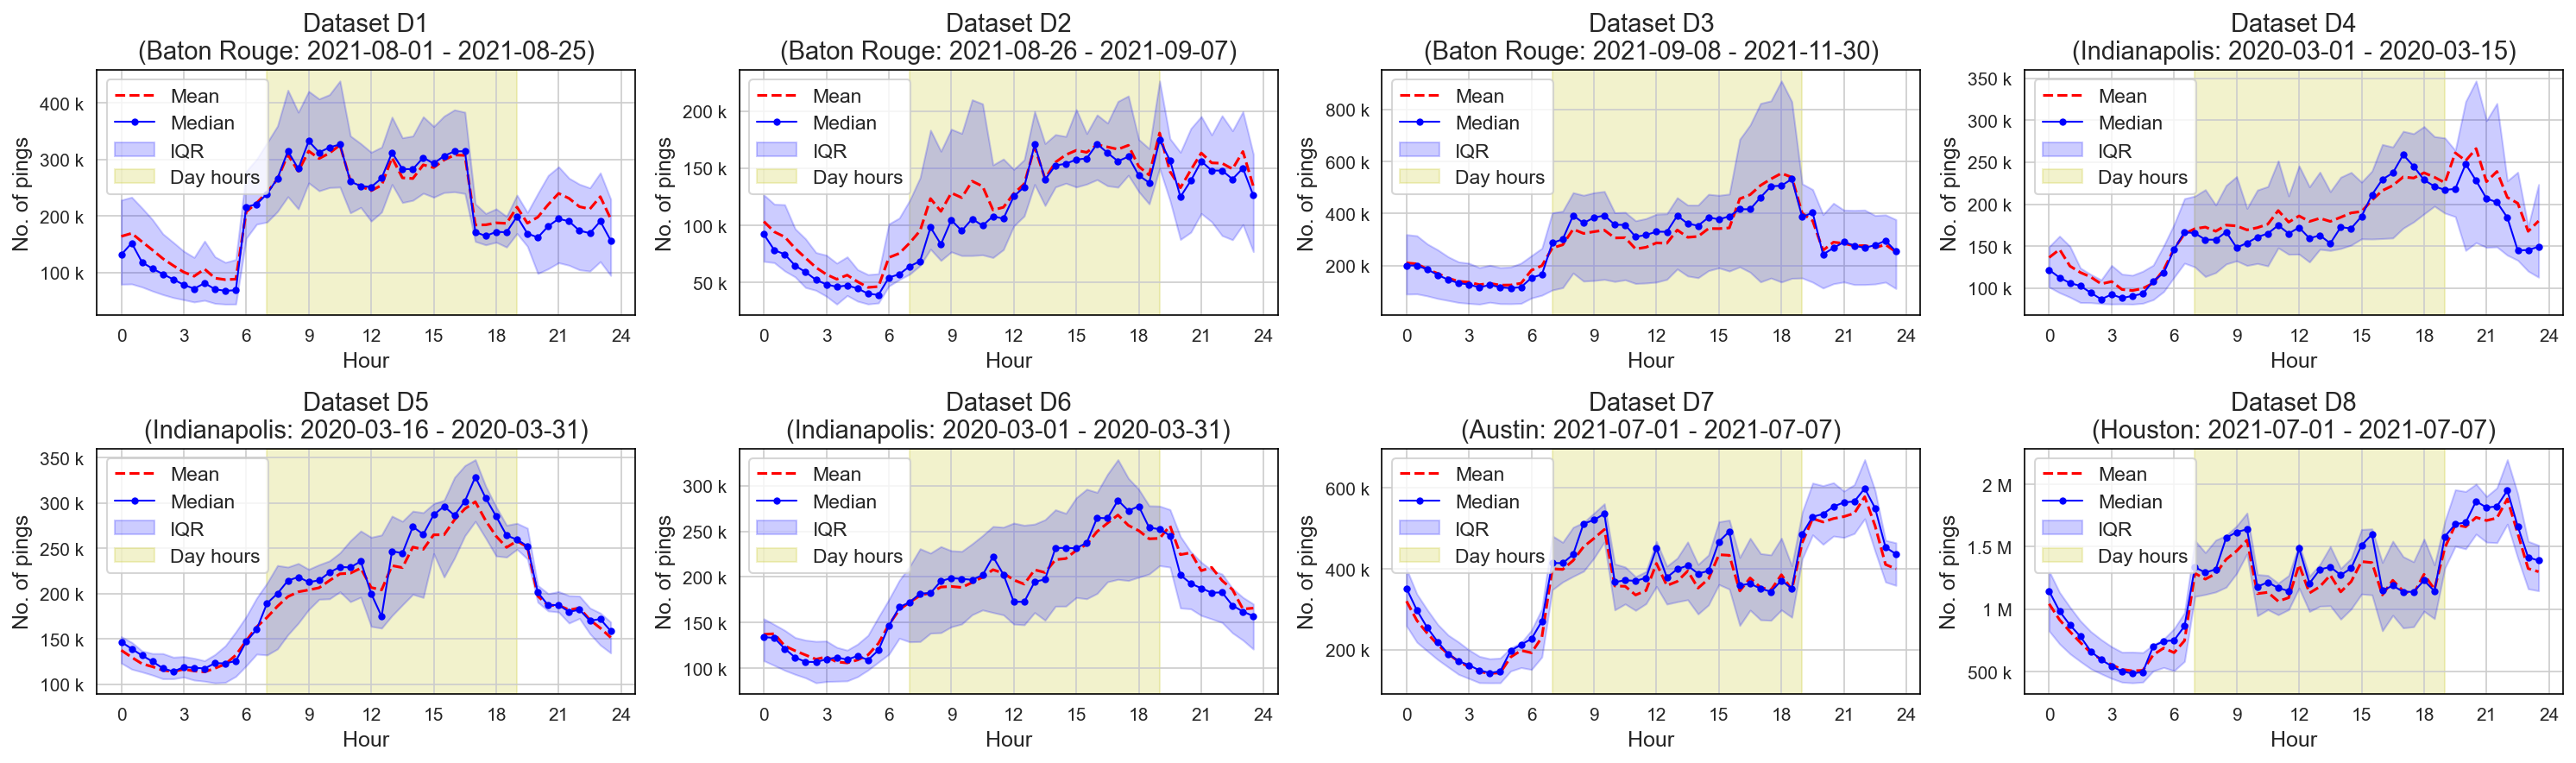

In [18]:
def plot_hourly_profile(datasets, day_hrs=base_day_hrs, ncol=4, size=(5, 3), dpi=100):
    nrow = int(np.ceil(len(datasets) / ncol))
    fig, axes = plt.subplots(nrow, ncol, dpi=dpi,
                             figsize=(size[0] * ncol, size[1] * nrow))
    axes = axes.flatten()
    for i, j in tqdm(list(it.product(range(nrow), range(ncol)))):
        k = i * ncol + j
        ax = axes[k]
        if k >= len(datasets):
            ax.axis('off')
            continue
        ds = datasets[k]
        df = get_ping_counts(ds)
        df = df.groupby('day_id', 'slot').agg(F.sum('n_pings').alias('n'))
        df = df.groupby('slot').agg(F.mean('n').alias('mean'), F.stddev('n').alias('std'),
                                    F.collect_list('n').alias('n'))
        df = df.withColumn('50%', F.udf(lambda x: float(np.median(x)), T.float)('n'))
        df = df.withColumn('75%', F.udf(lambda x: float(np.quantile(x, 0.75)), T.float)('n'))
        df = df.withColumn('25%', F.udf(lambda x: float(np.quantile(x, 0.25)), T.float)('n'))
        df = df.drop('n').toPandas().set_index('slot').sort_index()
        df.index /= 2
        ax = U.plot(ax, framebordercolor='k', yeng=1)
        df['mean'].plot(ax=ax, ls='--', color='r', label='Mean')
        df['50%'].plot(ax=ax, color='b', label='Median', lw=1, marker='.')
        ax.fill_between(df.index, df['25%'], df['75%'], color='b', alpha=0.2, label='IQR')
        ax.axvspan(*day_hrs, color='y', alpha=0.2, label='Day hours', zorder=-1)
        ax.set_xticks(np.arange(0, 24+1, 3))
        ax = U.plot(ax, xlab='Hour', ylab='No. of pings',
                    title='\n('.join(str(ds).split('(')))
        ax.legend(loc='upper left')
    plt.tight_layout()
    
%time x = plot_hourly_profile(datasets, dpi=150); x # t=0:14

## Data quality-quantity tradeoff matrix

In [19]:
def get_qq_tradeoff_matrix(ds):
    df = get_ping_counts(ds)
    user_pings = df.groupby(UID).agg(F.sum('n_pings').alias('nPings'))
    df = df.groupby(UID, 'day_id').count().withColumnRenamed('count', 'nSlots')
    df = df.groupby(UID, 'nSlots').count().withColumnRenamed('count', 'nDays')
    df = df.select(UID, 'nSlots', 'nDays').sort(F.col('nSlots').desc())
    udf = lambda nSlots, nDays: list(it.product(range(nSlots), range(nDays)))
    df = df.withColumn('cells', F.udf(udf, T.array(T.array(T.int)))('nSlots', 'nDays'))
    df = df.groupby(UID).agg(F.array_distinct(F.flatten(
        F.collect_list('cells'))).alias('cells'))
    df = user_pings.join(df, on=UID)
    df = df.select(UID, 'nPings', F.explode('cells').alias('cell'))
    df = df.groupby('cell').agg(F.countDistinct(UID).alias('nUsers'),
                                F.sum('nPings').alias('nPings')).sort('cell')
    df = df.withColumn('nSlots', F.col('cell')[0].cast(T.int))
    df = df.withColumn('nDays', F.col('cell')[1].cast(T.int))
    df = df.select('nSlots', 'nDays', 'nUsers', 'nPings')
    return df
    
# %time x = get_qq_tradeoff_matrix(datasets[0]); x

In [20]:
ds = datasets[0]
%time ds.qq_mat = get_qq_tradeoff_matrix(ds).toPandas().disp()

1,152 rows x 4 cols; Memory: 0.0 MiB


,nSlots,nDays,nUsers,nPings
,<int32>,<int32>,<int64>,<int64>
0,0,0,434768,261037754


CPU times: user 78.8 ms, sys: 19.9 ms, total: 98.6 ms
Wall time: 15.4 s


### Plot tradeoff matrix

In [21]:
def plot_quality_quantity_tradeoff_matrix(
    rgn, slot_interval=3, day_interval=1, max_day=None, max_slot=None,
    size=(12, 2), dpi=120, cmap='Greens', annot_size=8
):
    df = pd.read_parquet(rgn.data / f'stats/qq_tradeoff_matrix')
    tot_users, tot_pings = df.iloc[0]['n_users'], df.iloc[0]['n_pings']
    fig, axs = plt.subplots(1, 2, figsize=size, dpi=dpi)
    for ax, var in zip(axs, ['users', 'pings']):
        total = df.iloc[0]['n_'+var]
        mat = df.pivot(index='n_days', columns='n_slots', values='n_'+var)
        mat = (mat.fillna(0) / total) * 100
        mat = mat.loc[:max_day:day_interval, :max_slot:slot_interval]
        g = sns.heatmap(ax=ax, data=mat, cmap=cmap, annot=True,
                        fmt='.0f', annot_kws=dict(fontsize=annot_size))
        g.set_xticklabels(g.get_xticklabels(), rotation=90)
        g.set_yticklabels(g.get_yticklabels(), rotation=0)
        ax = U.plot(ax, title='Percent of total {} ($n=${:,.1f}M) filtered'
                    .format(var, total/1e6),
                    xlab='No. of ½-hr bins', ylab='No. of days')
    plt.subplots_adjust(wspace=0.03)
    P.imsave(title=f'Data quality-quantity tradeoff matrix for {rgn.name}')

### Figure: Data quality-quantity tradeoff matrix